In [1]:
import numpy as np
import matplotlib.pylab as plt
import pickle
import tqdm as tq

In [2]:
def forward(m, S, b, A, Sigma, dt):
    
    for i in range(len(b) - 1):
        # Euler step for m and S ODEs
        m[i + 1] = m[i] - (np.dot(A[i], m[i]) - b[i]) * dt
        S[i + 1] = S[i] - (np.dot(A[i], S[i]) + np.dot(S[i], A[i].T) - Sigma) * dt
    return m, S

In [3]:
def backward(t_grid, A, b, m, S, Sigma, r, psi, lamda, t_dict, x, dt):
    
    # Arrays for storing the updates for A and b
    A_ = np.zeros_like(A)
    b_ = np.zeros_like(b)
    KL = 0
    
    for i in range(len(b) - 1, 0, -1):
        
        KL += 8 * ((m[i] ** 6) + 15 * (m[i] ** 4) * S[i] + 45 * (m[i] ** 2) * (S[i] ** 2) + 15 * (S[i] ** 6)) / Sigma \
                - 4 * (4 + A[i]) * (m[i] ** 4 + 6 * m[i] ** 2 * S[i] + 3 * S[i] ** 2) / Sigma \
                + 4 * b[i] * (m[i] ** 3 + 3 * m[i] * S[i]) / Sigma \
                + (4 * A[i]) ** 2 * (m[i] ** 2 + S[i]) * 0.5 / Sigma \
                - b[i] * (4 + A[i]) * m[i] / Sigma + b[i] ** 2 * 0.5 / Sigma
        
        # Compute dEdS and dEdm
        dEdS = 8 / Sigma * (15 * m[i] ** 4 + 90 * m[i] ** 2 * S[i] + 45 * S[i] ** 2) \
                - 4 * (4 + A[i]) / Sigma * (16 * m[i] ** 2 + 6 * S[i]) \
                + 12 * b[i] * m[i] / Sigma + 0.5 * (4 + A[i]) ** 2 / Sigma 
        
        dEdm = 8 / Sigma * (6 * m[i] ** 5 + 60 * S[i] * m[i] ** 3 + 90 * S[i] ** 2 * m[i]) \
                - 4 * (4 + A[i]) / Sigma * (4 * m[i] ** 3 + 12 * S[i] * m[i]) \
                + 4 * b[i] * (3 * m[i] ** 2 + 3 * S[i]) / Sigma + (4 + A[i]) ** 2 * m[i] /Sigma \
                - b[i] * (4 + A[i]) / Sigma
        
        # Euler step for lambda and psi ODEs
        lamda[i - 1] = lamda[i] - (np.dot(A[i].T, lamda[i]) - dEdm) * dt
        psi[i - 1] = psi[i] - (2 * np.dot(psi[i], A[i]) - dEdS) * dt


        # Handle jump conditions at locations of the data
        if t_grid[i - 1] in t_dict:
            psi[i - 1] = psi[i - 1] + 0.5 * r ** -2
            lamda[i - 1] = lamda[i - 1] - r ** -2 * (x[t_dict[t_grid[i - 1]]] - m[i - 1])
            
    for i in range(len(b) - 1, -1, -1):
        A_[i] = -4 * (1 - 3 * m[i] ** 2 - 3 * S[i]) + 2 * np.dot(Sigma, psi[i])
        b_[i] = -4 * (m[i] ** 3 + 3 * m[i] * S[i]) + 4 * m[i] + np.dot(A_[i], m[i]) - np.dot(Sigma, lamda[i])
    return psi, lamda, b_, A_, KL

In [25]:
def smoothing(t_obs, t_grid, y_obs, num_passes, omega, Sigma,  r, dt, m0, S0):
    
    grid_size = t_grid.shape[0]
    
    # Dictionary mapping from times to indices for array x
    t_dict = dict(zip(t_obs, np.arange(0, len(t_obs))))
    
    b = np.zeros((grid_size, 1))
    A = np.zeros((grid_size, 1, 1))
    KL_ = np.zeros(num_passes)
    
    for i in tq.tqdm(range(num_passes)):

        lamda = np.zeros((grid_size, 1))
        psi = np.zeros((grid_size, 1, 1))

        m = m0 * np.ones((grid_size, 1))
        S = S0 * np.ones((grid_size, 1, 1))
        
        # Forward pass to compute m, S
        m, S = forward(m=m, S=S, b=b, A=A, Sigma=Sigma, dt=dt)
        
        # Backward pass to compute psi, lamda, b_, A_
        psi, lamda, b_, A_, KL = backward(t_grid=t_grid,
                                      A=A,
                                      b=b,
                                      m=m,
                                      S=S,
                                      Sigma=Sigma,
                                      r=r,
                                      psi=psi,
                                      lamda=lamda,
                                      t_dict=t_dict,
                                      x=y_obs,
                                      dt=dt)
        KL_[i] = KL
        
        if i > 100:
            omega = 0.05
        
        b = b + omega * (b_ - b)
        A = A + omega * (A_ - A)

    return b, A, m, S, psi, lamda, KL_

Load dataset

In [62]:
with open('EX04_DW', 'rb') as f:
    prior = pickle.load(f)
    likelihood = pickle.load(f)
    std = pickle.load(f)

In [63]:
def prior_drift (s, x_s):
    return 4 * x_s * (1 - (x_s ** 2))

In [64]:
true_sde_pts, true_sde_trj = prior[0], prior[1]
obs, obs_time = likelihood[0], likelihood[1]
sde_sigma, obs_sigma = std[0], std[1]

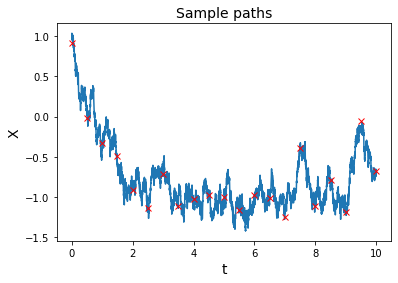

In [65]:
# Plot paths
plt.plot(true_sde_pts,true_sde_trj)
plt.plot(obs_time, obs, "rx")
plt.xlabel("t", fontsize=14)
plt.ylabel("X", fontsize=14)
plt.title("Sample paths", fontsize=14)
plt.show()


In [42]:
t_obs = obs_time
y_obs = obs.flatten()

In [49]:
# Algorithm parameters
num_passes = 1000
Sigma = sde_sigma ** 2 * np.eye(1)
omega = 0.007 # If it is any higher than, the algorithm explodes
m0 = y_obs[0]
S0 = 0.04

t_grid = true_sde_pts
grid_size = t_grid.shape[0]
dt = (true_sde_pts[1] - true_sde_pts[0])

In [50]:
# Run the smoothing algorithm
b, A, m, S, psi, lamda, KL = smoothing(t_obs=t_obs,
                                   t_grid=t_grid,
                                   y_obs=y_obs,
                                   num_passes=num_passes,
                                   omega=omega,
                                   Sigma=Sigma,
                                   r=obs_sigma,
                                   dt=dt,
                                   m0=m0,
                                   S0=S0)

100%|███████████████████████████████████████| 1000/1000 [25:11<00:00,  1.51s/it]


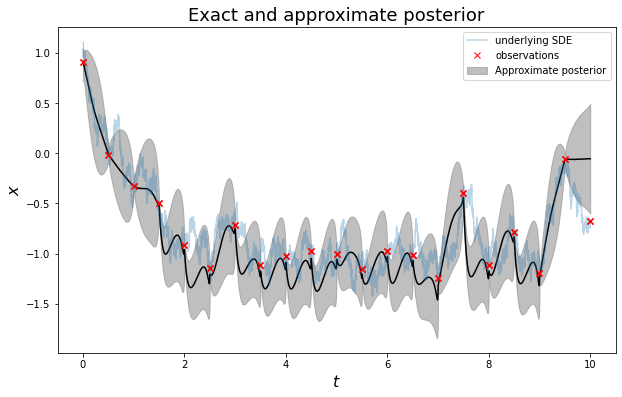

In [69]:
# Plot data, approximate and exact posterior
plt.figure(figsize=(10, 6))

# Observed data
plt.scatter(t_obs, y_obs, marker='x', color='red', zorder=3)

# Approximate posterior
plt.plot(t_grid, m[:, 0], color='black', zorder=2)
plt.fill_between(t_grid,
                 m[:, 0] - S[:, 0, 0] ** 0.5,
                 m[:, 0] + S[:, 0, 0] ** 0.5,
                 color='gray',
                 alpha=0.5,
                 zorder=1,
                 label='Approximate posterior')

# Format plot
plt.title('Exact and approximate posterior', fontsize=18)
plt.xlabel('$t$', fontsize=16)
plt.ylabel('$x$', fontsize=16)
plt.plot(true_sde_pts, true_sde_trj, alpha=0.3, label='underlying SDE')
plt.plot(obs_time, obs, "rx", label='observations')
plt.legend()
plt.show()

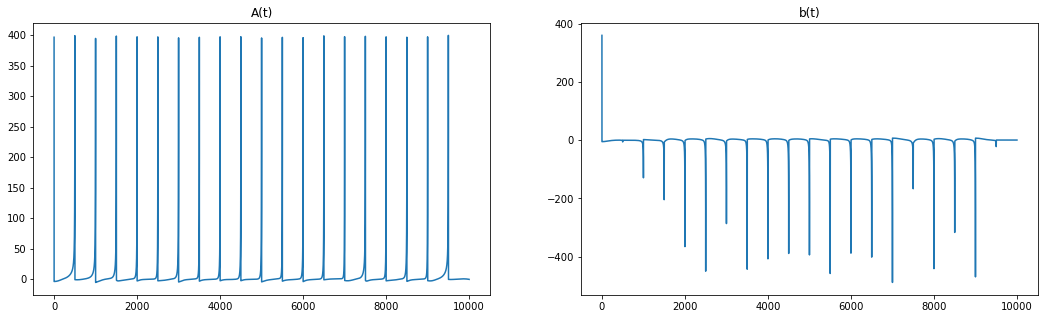

In [52]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))
ax[0].plot(A.flatten())
ax[0].set_title("A(t)")
ax[1].plot(b.flatten())
ax[1].set_title("b(t)")
plt.show()

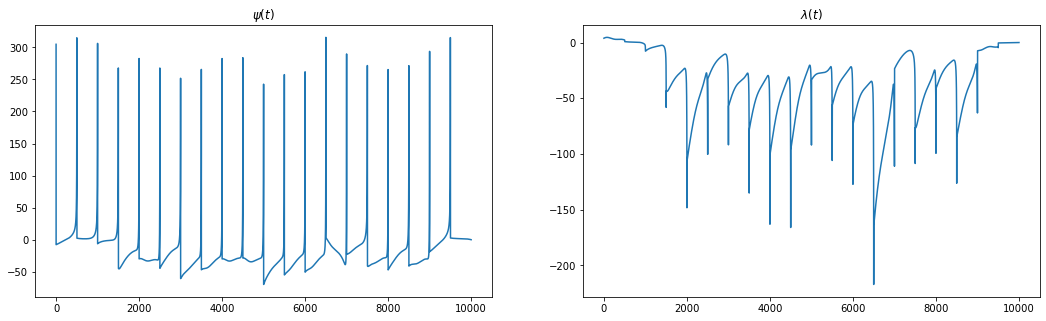

In [53]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))
ax[0].plot(psi.flatten())
ax[0].set_title(r"$\psi(t)$")
ax[1].plot(lamda.flatten())
ax[1].set_title(r"$\lambda(t)$")
plt.show()

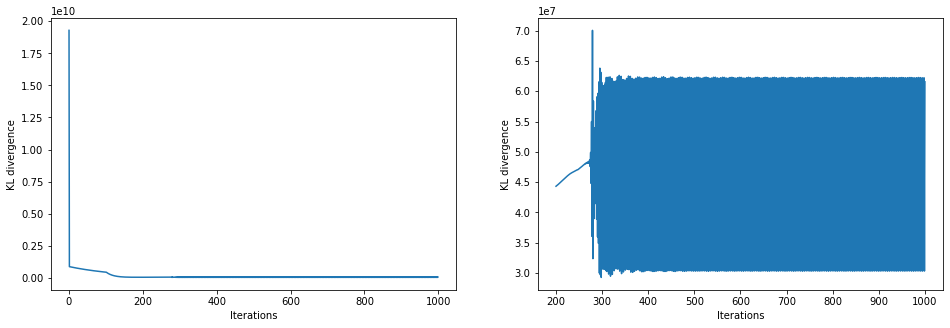

In [91]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

ax[0].plot(np.arange(KL.shape[0]), KL)
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("KL divergence")

ax[1].plot(np.linspace(200, 1000, 800), KL[200:])
ax[1].set_ylabel("KL divergence")
ax[1].set_xlabel("Iterations")
plt.show()

In [95]:
output = [b, A, m, S, psi, lamda, KL]

In [96]:
with open('EX04_DW_ARC', 'wb') as f:
    pickle.dump(output, f)